In [20]:
##
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.pipeline import Pipeline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# df = pd.read_csv("./cleaned_soccer_data_v1.csv",index_col=0)
df = pd.read_csv("../../datasets/cleaned_soccer_data_2016_v2.csv",index_col=0)
print(df.head())
print(df.columns)
print(df["player_positions"])


    id  player_fifa_api_id  player_api_id        date  overall_rating  \
0    1              218353         505942  2016-02-18            67.0   
1    6              189615         155782  2016-04-21            74.0   
2   65              140161          30572  2016-04-21            69.0   
3   88               17725          23780  2015-12-24            70.0   
4  113              158138          27316  2016-04-28            77.0   

   potential  crossing  finishing  heading_accuracy  short_passing  ...  \
0       71.0      49.0       44.0              71.0           61.0  ...   
1       76.0      80.0       53.0              58.0           71.0  ...   
2       69.0      57.0       21.0              68.0           65.0  ...   
3       70.0      46.0       34.0              73.0           65.0  ...   
4       77.0      77.0       72.0              64.0           79.0  ...   

   height  weight  preferred_foot_left  preferred_foot_right  \
0  182.88     187                    0        

In [21]:
# take only one position
df["player_positions"] = df["player_positions"].apply(lambda x: x.split()[-1]).astype('category')

# print(df["player_positions"].cat.codes)
# print(df["player_positions"].cat.categories)
player_positions_detailed = df["player_positions"] # save for use later
print(df["player_positions"])

# player_pos_codes = df["player_positions"]

0        CB
1        LB
2        RB
3        CB
4        LM
       ... 
6353    CAM
6354     ST
6355     RM
6356     LW
6357     LB
Name: player_positions, Length: 6358, dtype: category
Categories (15, object): ['CAM', 'CB', 'CDM', 'CF', ..., 'RM', 'RW', 'RWB', 'ST']


In [22]:
GK = set(['GK'])
DEF = set(['LWB', 'RWB', 'LB', 'CB', 'RB'])
MID = set(['CAM', 'LM', 'CM', 'RM'])
ATK = set(['ST', 'LW', 'CF', 'RW'])

# sort positions into general position labels
def general_positions(pos):
    if pos in GK:
        return "GK"
    elif pos in DEF:
        return "DEF"
    elif pos in ATK:
        return "ATK"
    elif pos in MID:
        return "MID"

player_positions_general = player_positions_detailed.apply(general_positions).astype('category')
player_positions_general

0       DEF
1       DEF
2       DEF
3       DEF
4       MID
       ... 
6353    MID
6354    ATK
6355    MID
6356    ATK
6357    DEF
Name: player_positions, Length: 6358, dtype: category
Categories (4, object): ['ATK', 'DEF', 'GK', 'MID']

In [23]:
df["player_positions_general"]=player_positions_general
# df.to_csv("./cleaned_soccer_data_2016_v3_with general_labels.csv")
# df


In [24]:
# drop features that do not mean anything
ohe_positions = ['ls', 'st', 'rs', 'lw', 'lf', 'cf',
       'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb',
       'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb']
df = df.drop("player_positions",1)
df = df.drop("player_positions_general",1)
player_fifa_id=df["player_fifa_api_id"]
df = df.drop("player_fifa_api_id",1)
df = df.drop("player_api_id",1)
df = df.drop("player_name",1)
df = df.drop("date",1)

In [25]:
# drop if we dont want features in the labels
df = df.drop(ohe_positions,1)

In [26]:
# drop binary features for better visualization
binary_features= ["preferred_foot_left",
"preferred_foot_right",
	"attacking_work_rate_high",
    	"attacking_work_rate_low",
        	"attacking_work_rate_medium",
            	"defensive_work_rate_high",
                	"defensive_work_rate_low",
                    	"defensive_work_rate_medium"
]
# df = df.drop(binary_features,1)

In [27]:
# ensure all columns are numeric
print(df.dtypes)

id                              int64
overall_rating                float64
potential                     float64
crossing                      float64
finishing                     float64
heading_accuracy              float64
short_passing                 float64
volleys                       float64
dribbling                     float64
curve                         float64
free_kick_accuracy            float64
long_passing                  float64
ball_control                  float64
acceleration                  float64
sprint_speed                  float64
agility                       float64
reactions                     float64
balance                       float64
shot_power                    float64
jumping                       float64
stamina                       float64
strength                      float64
long_shots                    float64
aggression                    float64
interceptions                 float64
positioning                   float64
vision      

In [28]:
# normalise before doing PCA otherwise variance is unbalanced
'''
 Normalization usually means to scale a variable to have a 
 values between 0 and 1, while standardization transforms 
 data to have a mean of zero and a standard deviation of 1
 
 Sklearn PCA only centers the variables. So the sklearn PCA does not feature scale the data beforehand.
 
 Centering a variable is subtracting the mean of the variable from each data point so that the new variable's mean is 0; 
 scaling a variable is multiplying each data point  by a constant in order to alter the range of the data.
'''

#IMPT
def normalize(df):
    return (df-df.min())/(df.max()-df.min()) 

df = normalize(df)

print(df.head())




         id  overall_rating  potential  crossing  finishing  heading_accuracy  \
0  0.000000        0.413043   0.465116  0.494118   0.426966          0.724138   
1  0.000027        0.565217   0.581395  0.858824   0.528090          0.574713   
2  0.000348        0.456522   0.418605  0.588235   0.168539          0.689655   
3  0.000473        0.478261   0.441860  0.458824   0.314607          0.747126   
4  0.000609        0.630435   0.604651  0.823529   0.741573          0.643678   

   short_passing   volleys  dribbling     curve  ...    height    weight  \
0       0.617284  0.448276   0.488636  0.453488  ...  0.529412  0.521368   
1       0.740741  0.402299   0.738636  0.744186  ...  0.235294  0.170940   
2       0.666667  0.494253   0.545455  0.372093  ...  0.529412  0.615385   
3       0.666667  0.321839   0.443182  0.418605  ...  0.529412  0.239316   
4       0.839506  0.827586   0.795455  0.825581  ...  0.529412  0.299145   

   preferred_foot_left  preferred_foot_right  attacking_

In [123]:
# visualization
# https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57

def single_player(df):
    ax = df.iloc[[0]].plot.bar()
    plt.show()

# single_player(df)

In [124]:
def hist_plot_1d(df):
    df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
            xlabelsize=8, ylabelsize=8, grid=False)    
    plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
    plt.show()

# hist_plot_1d(df)

In [125]:
# may need to drop binary features to see heatmap better
# df = df.drop(binary_features,1)
def corr_mat(df):
    f, ax = plt.subplots(figsize=(10, 6))
    corr = df.corr()
    hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                    linewidths=.05)
    f.subplots_adjust(top=0.93)
    t= f.suptitle('Soccer Player Attributes Correlation Heatmap', fontsize=14)
    plt.show()

# corr_mat(df)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [46] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


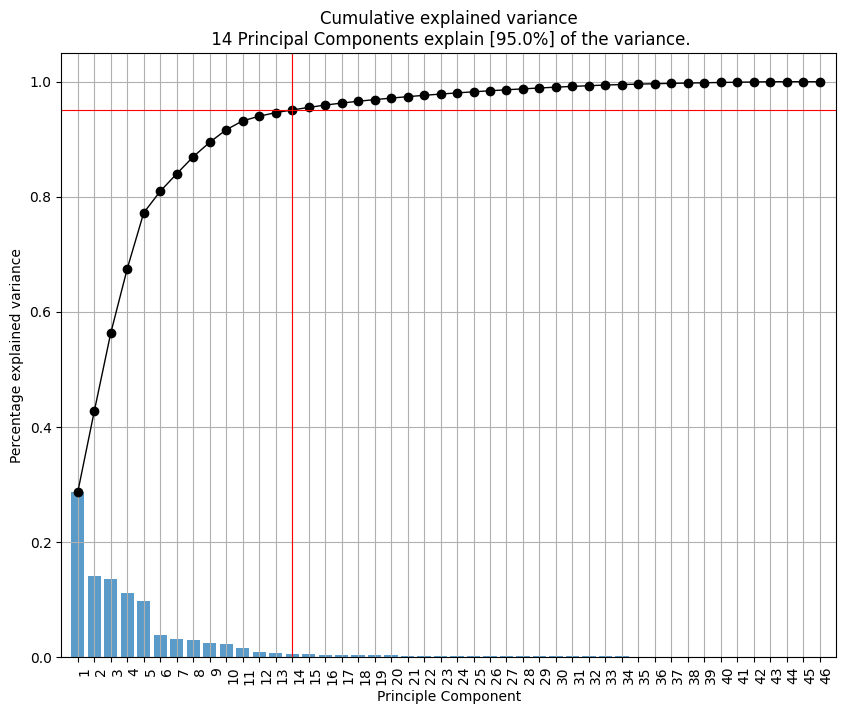

<Figure size 1200x800 with 0 Axes>

In [29]:
# pca? https://builtin.com/data-science/step-step-explanation-principal-component-analysis
# https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e

'''
So, the idea is 10-dimensional data gives you 10 principal components,
 but PCA tries to put maximum possible information in the first component, 
 then maximum remaining information in the second and so on

 The resulting projected data are essentially linear combinations of 
 the original data capturing most of the variance in the data



 If you don't have any strict constraints, I recommend plotting the cumulative sum 
 of eigenvalues (assuming they are in descending order). 
 If you divide each value by the total sum of eigenvalues 
 prior to plotting, then your plot will show the fraction 
 of total variance retained vs. number of eigenvalues. 
 The plot will then provide a good indication of when you 
 hit the point of diminishing returns 
 (i.e., little variance is gained by retaining additional 
 eigenvalues).

 Reduce dimensions due to the Curse of Dimensionality

 If the PCA display* our K clustering result to be orthogonal or close to, then it is a sign that our clustering 
 is sound , each of which exhibit unique characteristics
'''

def check_n_pcs(df):
    from pca import pca #nicer library but bottom part does not work
    model = pca(n_components=0.95) # gives 14pcs
    model.fit_transform(df)
    # Initialize to reduce the data up to the number of componentes that explains 95% of the variance n_pc=16.
    fig, ax = model.plot()
    plt.show()

check_n_pcs(df)




In [30]:
num_pc=11 #14 for no ohe_position features
pca = PCA(n_components=num_pc)
# pca.fit(df)
df_pca = pca.fit_transform(df)

# print(pca.components_) #eigenvectors pca.components_ has shape [n_components, n_features]
# print(pca.explained_variance_) #eigenvalues
# plt.plot(pca.explained_variance_)
# plt.show() # diminishing returns at 6 PCs
print(pca.explained_variance_ratio_)


[0.28678832 0.14023313 0.13600582 0.11188652 0.09723953 0.03739106
 0.03040656 0.02962768 0.02510691 0.02179675 0.01544915]


<ipython-input-32-4ec47ff7b1e6>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def scatter_pca_sns(df,df_pca,num_pc,labels=pd.Series()):


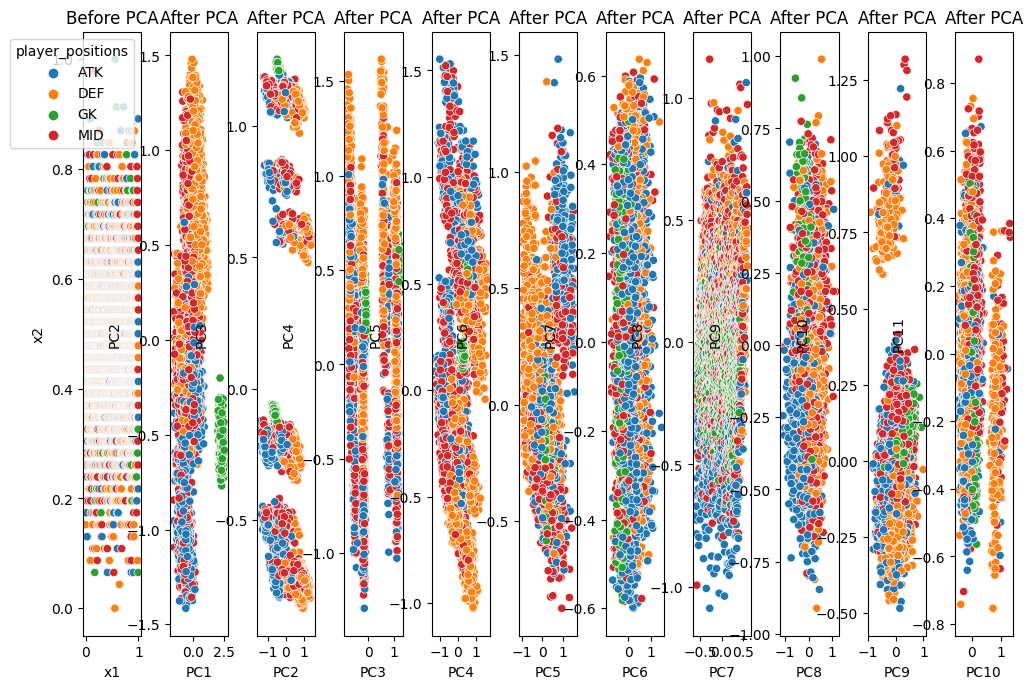

In [32]:


def scatter_pca_sns(df,df_pca,num_pc,labels=pd.Series()):
    fig, axes = plt.subplots(1,num_pc)
    if not labels.empty:
        sns.scatterplot(data=df, x=df.iloc[:,0], y=df.iloc[:,1], hue=labels,ax=axes[0])
    else:
        sns.scatterplot(data=df, x=df.iloc[:,0], y=df.iloc[:,1],ax=axes[0])
    axes[0].set_xlabel('x1')
    axes[0].set_ylabel('x2')
    axes[0].set_title('Before PCA')
    for i in range(1,num_pc):
        if not labels.empty:
            sns.scatterplot(data=df_pca, x=df_pca[:,i-1], y=df_pca[:,i], hue=labels,ax=axes[i],legend=False)
        else:
            sns.scatterplot(data=df, x=df_pca[:,i-1], y=df_pca[:,i],ax=axes[i],legend=False)
        axes[i].set_xlabel('PC{}'.format(i))
        axes[i].set_ylabel('PC{}'.format(i+1))
        axes[i].set_title('After PCA')
    plt.subplots_adjust(wspace=0.5)
    plt.show()
    
# scatter_pca_sns(df,df_pca,num_pc,labels=player_positions_detailed)
scatter_pca_sns(df,df_pca,num_pc,labels=player_positions_general)


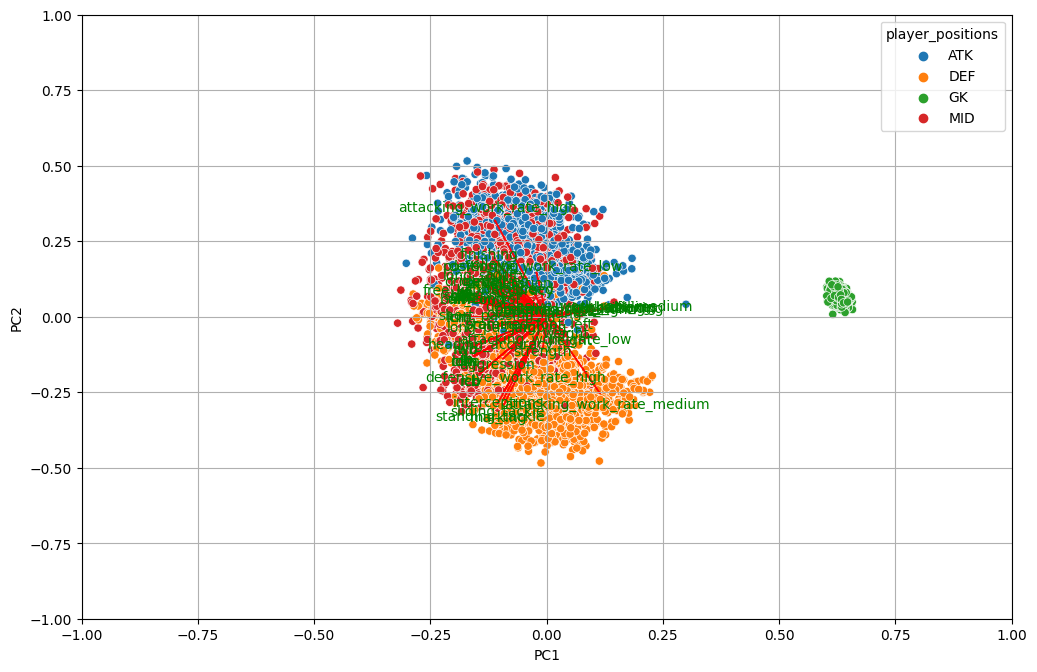

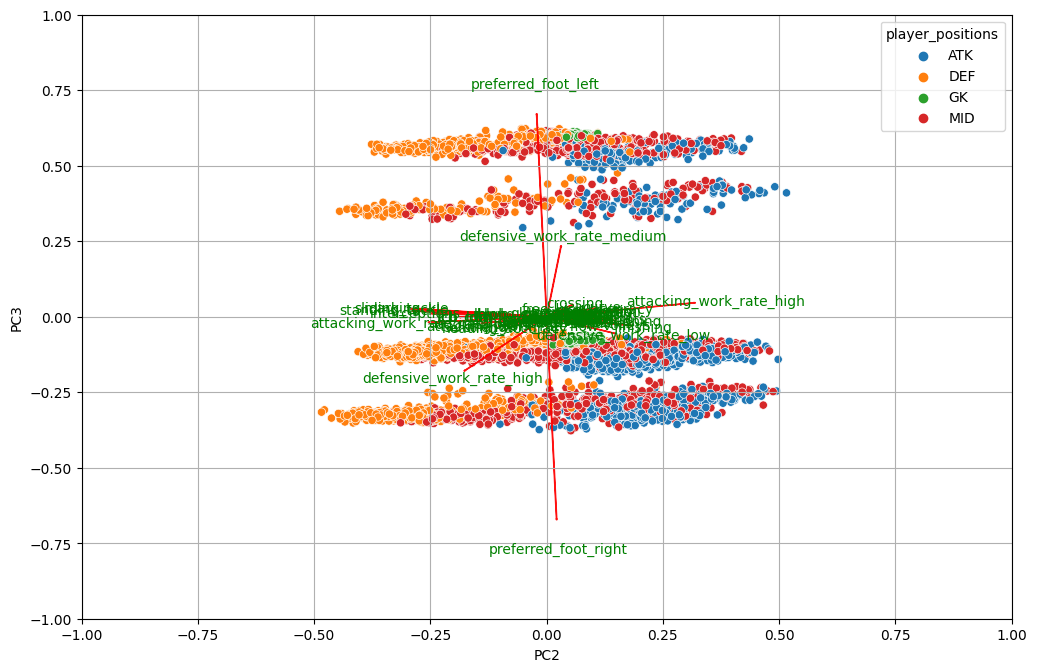

In [15]:

def biplot(df,score,coeff,num_pc,labels=None):
    '''
    score: the projected data
    coeff: the eigenvectors (PCs)
    pcax: pca1 index
    pcay: pca2 index
    '''
    for i in range(0,num_pc-1):
        pca1=i
        pca2=i+1
        xs = score[:,i]
        ys = score[:,i+1]
        n=coeff.shape[0]
        scalex = 1.0/(xs.max()- xs.min())
        scaley = 1.0/(ys.max()- ys.min())
        if labels is None:
            sns.scatterplot(data=score, x=xs*scalex, y=ys*scaley)
        else:
            sns.scatterplot(data=score, x=xs*scalex, y=ys*scaley, hue=labels)
        for j in range(n): #feature explain variance
            plt.arrow(0, 0, coeff[j,pca1], coeff[j,pca2],color='r',alpha=0.9) 
            if labels is None:
                plt.text(coeff[j,pca1]* 1.15, coeff[j,pca2] * 1.15,  list(df.columns)[j], color='g', ha='center', va='center')
            else:
                plt.text(coeff[j,pca1]* 1.15, coeff[j,pca2] * 1.15, list(df.columns)[j], color='g', ha='center', va='center')
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        plt.xlabel("PC{}".format(pca1+1))
        plt.ylabel("PC{}".format(pca2+1))
        plt.grid()
        plt.show()

# Call the biplot function for any number of PCs
biplot(df,df_pca, np.transpose(pca.components_),3,player_positions_general)



In [16]:
# check if plot is correct
# Var 33 and Var 31 are extremely positively correlated
print(np.corrcoef(df.iloc[:,33], df.iloc[:,31])[1,0])
# Var 36 and Var 37 are negatively correlated
print(np.corrcoef(df.loc[:,"preferred_foot_right"], df.loc[:,"preferred_foot_left"])[1,0] )

0.9615529569794249
-0.9999999999999999


In [17]:
columns=["PC{}".format(i) for i in range(1,num_pc+1)]
df_pca = pd.DataFrame(df_pca,columns=columns,index=df.index)
df_pca["player_fifa_api_id"]=player_fifa_id
print(df_pca.head())


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.229619 -0.671994 -0.223798 -0.295721 -0.411402  0.224269 -0.042255   
1 -1.102511  0.106931  1.209139  0.740528 -0.396603 -0.205634  0.227289   
2  0.323213 -0.965183 -0.230219 -0.191440 -0.441475  0.339714 -0.238729   
3  0.373111 -1.064630 -0.226915 -0.141868 -0.471729  0.326779 -0.102140   
4 -0.942109  0.464117  1.049003 -0.843253  0.236870 -0.194382 -0.517059   

        PC8       PC9      PC10      PC11  player_fifa_api_id  
0  0.500229 -0.141907 -0.116746  0.147774              218353  
1  0.561565  0.179913  0.020062 -0.042158              189615  
2  0.443558  0.079021 -0.129468  0.257416              140161  
3  0.478194  0.019064 -0.115875  0.241034               17725  
4  0.398993  0.126400  0.148374 -0.061061              158138  


In [18]:
df_org = pd.read_csv("../../datasets/cleaned_soccer_data_2016_v2.csv",index_col=0)
df_org = df_org.loc[:,["player_positions","player_fifa_api_id"]]
df_final = pd.merge(df_org, df_pca, how='outer')
df_final["player_positions_general"] = player_positions_general
df_final

,player_positions,player_fifa_api_id,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,player_positions_general
0,CB,218353,0.229619,-0.671994,-0.223798,-0.295721,-0.411402,0.224269,-0.042255,0.500229,-0.141907,-0.116746,0.147774,DEF
1,LB,189615,-1.102511,0.106931,1.209139,0.740528,-0.396603,-0.205634,0.227289,0.561565,0.179913,0.020062,-0.042158,DEF
2,"CB, RB",140161,0.323213,-0.965183,-0.230219,-0.191440,-0.441475,0.339714,-0.238729,0.443558,0.079021,-0.129468,0.257416,DEF
3,CB,17725,0.373111,-1.064630,-0.226915,-0.141868,-0.471729,0.326779,-0.102140,0.478194,0.019064,-0.115875,0.241034,DEF
4,"CAM, CM, LM",158138,-0.942109,0.464117,1.049003,-0.843253,0.236870,-0.194382,-0.517059,0.398993,0.126400,0.148374,-0.061061,MID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6353,"RM, LM, CAM",179712,-0.533128,0.688203,1.075923,-0.859208,0.281946,-0.381340,0.114382,-0.457694,-0.181102,0.219477,-0.041897,MID
6354,ST,219943,0.430020,-0.153972,-0.270089,-0.460028,-0.273260,0.238402,0.066172,-0.508681,-0.449866,-0.207811,-0.031334,ATK
6355,RM,105454,-1.088804,1.313059,1.123718,0.275971,-0.092953,-0.387493,0.035354,-0.504197,0.057395,0.140259,-0.101244,MID
6356,"LM, LW",195840,0.037826,0.377686,1.068223,-0.644030,0.260095,0.014852,-0.056351,-0.530171,-0.440279,-0.041887,-0.022414,ATK


In [19]:
df_final.to_csv("./soccer_player_embeddings_feature_no_labels.csv")
# df_final.to_csv("./soccer_player_embeddings_feature_labels.csv")
# combinations

# multi class classification for neural net
# https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab